# 03 - Product Category Clustering

## Objective
Group Amazon electronics products into 5 meta-categories using semantic
embeddings and K-Means clustering. Evaluate clustering quality against
ground-truth labels (primaryCategories from DS3).

## Approach
1. Encode product names using Sentence Transformers (semantic embeddings)
2. Apply K-Means (k=5) to group semantically similar products
3. Evaluate using Adjusted Rand Index vs ground truth labels
4. Visualize clusters in 2D using UMAP

In [ ]:
# Install required packages
#!pip install sentence-transformers umap-learn scikit-learn matplotlib seaborn -q

In [ ]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    adjusted_rand_score,
    silhouette_score,
    normalized_mutual_info_score
)
from sklearn.manifold import TSNE
import umap

print("All packages loaded successfully")

# Reproducibility
RANDOM_STATE = 42



In [ ]:
# Load the electronics dataset (already has meta_category assigned)

# Google Colab
#df = pd.read_csv('/content/repo/data/processed/electronics_ready.csv')

# Local file
df = pd.read_csv('../data/processed/electronics_ready.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (30487, 4)

Columns: ['name', 'brand', 'rating', 'review_text']

First few rows:


,name,brand,rating,review_text
0,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,5,This product so far has not disappointed. My c...
1,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,5,great for beginner or experienced person. Boug...
2,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,5,Inexpensive tablet for him to use and learn on...
3,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,4,I've had my Fire HD 8 two weeks now and I love...
4,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,5,I bought this for my grand daughter when she c...


## Data transformation



In [5]:
def assign_meta_category(name):
    """
    Assign products to one of 5 meta-categories based on name keywords.
    Uses the category hierarchy determined during EDA.
    """
    if pd.isna(name):
        return "Unknown"
    
    name_lower = name.lower()
    
    # Order matters — Kids must come before general Tablets
    if any(kw in name_lower for kw in ["kids edition", "kid-proof"]):
        return "Fire Kids Edition"
    
    elif any(kw in name_lower for kw in ["fire tablet", "fire hd", "fire 7", 
                                          "fire 8", "fire 10", " fire ", "tablet"]):
        return "Fire Tablets"
    
    elif any(kw in name_lower for kw in ["kindle", "e-reader", "ebook", 
                                          "paperwhite", "voyage", "oasis"]):
        return "Kindle E-Readers"
    
    elif any(kw in name_lower for kw in ["echo", "tap", "alexa"]):
        return "Echo & Smart Speakers"
    
    elif any(kw in name_lower for kw in ["fire tv", "firetv", "streaming", 
                                          "media player"]):
        return "Fire TV & Streaming"
    
    else:
        return "Accessories & Other"

# Apply to full dataset
df["meta_category"] = df["name"].apply(assign_meta_category)

print("Meta-category distribution:")
print(df["meta_category"].value_counts())

# Check what landed in "Other"
other_products = df[df["meta_category"] == "Accessories & Other"]["name"].unique()
print(f"\nProducts in 'Accessories & Other': {len(other_products)}")
if len(other_products) < 20:
    print(other_products)

Meta-category distribution:
meta_category
Fire Tablets             19739
Echo & Smart Speakers     4262
Kindle E-Readers          4231
Fire Kids Edition         2191
Accessories & Other         58
Fire TV & Streaming          6
Name: count, dtype: int64

Products in 'Accessories & Other': 9
<StringArray>
[                         'Coconut Water Red Tea 16.5 Oz (pack of 12)',
                     'AmazonBasics Nylon CD/DVD Binder (400 Capacity)',
                     'AmazonBasics Ventilated Adjustable Laptop Stand',
                   'AmazonBasics Backpack for Laptops up to 17-inches',
                                'AmazonBasics 11.6-Inch Laptop Sleeve',
                               'AmazonBasics External Hard Drive Case',
 'AmazonBasics USB 3.0 Cable - A-Male to B-Male - 6 Feet (1.8 Meters)',
                       'AmazonBasics 16-Gauge Speaker Wire - 100 Feet',
         'AmazonBasics Bluetooth Keyboard for Android Devices - Black']
Length: 9, dtype: str


In [6]:
# ── Aggregate reviews to product level ────────────────────────
# For clustering, we need one row per product with all its reviews concatenated

products_df = (
    df.groupby("name")
    .agg(
        meta_category=("meta_category", "first"),  # should be identical for all reviews of same product
        review_count=("review_text", "count"),
        avg_rating=("rating", "mean"),
        all_reviews=("review_text", lambda x: " ".join(x[:10]))  # concatenate up to 10 reviews per product
    )
    .reset_index()
)

print(f"Products: {len(products_df):,}")
print(f"Min reviews per product: {products_df['review_count'].min()}")
print(f"Max reviews per product: {products_df['review_count'].max()}")

# Remove "Accessories & Other" if too small to form a cluster
if (products_df["meta_category"] == "Accessories & Other").sum() < 5:
    products_df = products_df[products_df["meta_category"] != "Accessories & Other"]
    print(f"\nRemoved 'Accessories & Other' (too few products)")
    print(f"Final product count: {len(products_df):,}")

Products: 80
Min reviews per product: 1
Max reviews per product: 10961


In [ ]:
# ── Load Sentence Transformer model ───────────────────────────
model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model loaded.")

# ── Encode product names + review snippets ────────────────────
# Combine name and review text for richer semantic representation
texts_to_encode = (
    products_df["name"] + " " + products_df["all_reviews"]
).tolist()

print(f"Encoding {len(texts_to_encode)} products...")
embeddings = model.encode(
    texts_to_encode,
    show_progress_bar=True,
    batch_size=32,
    normalize_embeddings=True
)

print(f"Embedding shape: {embeddings.shape}")
# Should be (n_products, 384) — MiniLM produces 384-dim vectors

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Work\Documents\Ironhack - PM\lab-chatbot\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Work\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded.
Encoding 80 products...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embedding shape: (80, 384)


## Training

In [8]:
kmeans = KMeans(
    n_clusters=5,
    random_state=RANDOM_STATE,
    n_init=20
)

products_df["cluster"] = kmeans.fit_predict(embeddings)

print(products_df["cluster"].value_counts())


cluster
4    25
0    22
1    19
3     8
2     6
Name: count, dtype: int64


## Evaluation

In [9]:
ari = adjusted_rand_score(
    products_df["meta_category"],
    products_df["cluster"]
)

print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.236


In [10]:
nmi = normalized_mutual_info_score(
    products_df["meta_category"],
    products_df["cluster"]
)

print(f"NMI Score: {nmi:.3f}")


NMI Score: 0.385


In [11]:
sil_score = silhouette_score(embeddings, products_df["cluster"])
print(f"Silhouette Score: {sil_score:.3f}")


Silhouette Score: 0.136


In [12]:
pd.crosstab(
    products_df["meta_category"],
    products_df["cluster"]
)


cluster,0,1,2,3,4
meta_category,,,,,
Accessories & Other,1,1,0,7,0
Echo & Smart Speakers,0,11,0,0,1
Fire Kids Edition,1,0,0,0,4
Fire TV & Streaming,0,0,0,0,1
Fire Tablets,7,6,1,1,16
Kindle E-Readers,13,1,5,0,3


c:\Users\Work\Documents\Ironhack - PM\lab-chatbot\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


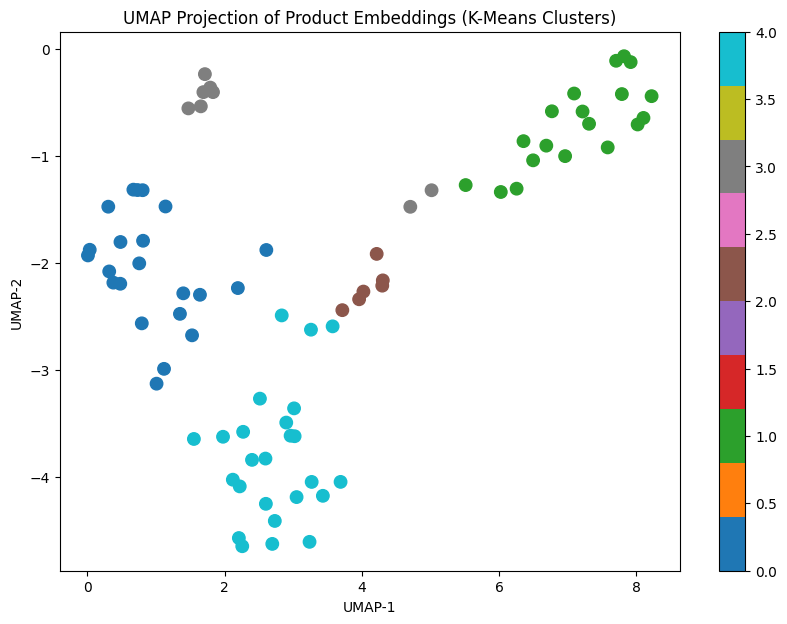

In [14]:
reducer = umap.UMAP(
    n_neighbors=10,
    min_dist=0.1,
    random_state=RANDOM_STATE
)

embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=products_df["cluster"],
    cmap="tab10",
    s=80
)

plt.title("UMAP Projection of Product Embeddings (K-Means Clusters)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter)
plt.savefig("../outputs/umap_product_embeddings.png", dpi=150)
plt.show()


In [ ]:
for k in [4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(embeddings)
    
    sil = silhouette_score(embeddings, labels)
    ari = adjusted_rand_score(products_df["meta_category"], labels)
    nmi = normalized_mutual_info_score(products_df["meta_category"], labels)
    
    print(f"k={k} → ARI: {ari:.3f} | NMI: {nmi:.3f} | Silhouette: {sil:.3f}")


k=4 → ARI: 0.266 | NMI: 0.372 | Silhouette: 0.114
k=5 → ARI: 0.236 | NMI: 0.385 | Silhouette: 0.136
k=6 → ARI: 0.237 | NMI: 0.395 | Silhouette: 0.120


## Conclusion

### Embeddings over TF-IDF/Bag of Words

In this scenario semantic understanding of customer reviews is a more suited tool than TF-IDF that captures lexical similarity. Additionally customer reviews vary highly in wording. Given the goal was to group products based on overall semantic similarity rather than exact keyword overlap, that made Embeddings more appropriate. TF-IDF treats each word independently and cannot capture contextual meaning (e.g., “read on the tablet” vs “tablet case”). Sentence embeddings encode context and relationships between words, making them more suitable for product-level similarity.

### Model Selection `all-MiniLM-L6-v2`

This model is optimized for semantic similarity tasks, providing strong performance while remaining fast and efficient to train. Given the small dataset (80 products), a larger embedding model would not provide meaningful gains given its higher complexity and computational cost to train. 

### k Value

| k | Silhouette | ARI   | NMI   |
| - | ---------- | ----- | ----- |
| 4 | 0.114      | 0.266 | 0.372 |
| 5 | **0.136**  | 0.236 | 0.385 |
| 6 | 0.120      | 0.237 | 0.395 |

We evaluated k = {4,5,6} to understand if lowering k Value would bring us something meaningful.
While k=4 achieved slightly higher ARI (better alignment with rule-based categories), k=5 achieved the highest Silhouette Score, indicating stronger internal cluster cohesion.
Since clustering is unsupervised and rule-based labels are noisy, we kept k=5 as the final model. Given the small number of products (n=80), moderate ARI values are expected, as small sample clustering is inherently sensitive to minor semantic overlaps.

### Interpretation of results

* Smart speakers and streaming devices formed clean clusters.

* Tablets and e-readers partially overlapped due to shared functional language.

* This suggests embeddings capture deeper semantic similarity beyond keyword-based grouping.

Overall, clustering demonstrated moderate alignment with predefined meta-categories while revealing meaningful semantic relationships between product types.